In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
K_MEANS = 3

train_df = pd.read_csv('./K_means/K_means_train.csv')
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             151 non-null    int64  
 1   SepalLengthCm  151 non-null    float64
 2   SepalWidthCm   151 non-null    float64
 3   PetalLengthCm  151 non-null    float64
 4   PetalWidthCm   151 non-null    float64
 5   Labels         151 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None


In [5]:
train_x_df = train_df.iloc[:, 1:]
print(train_x_df)

     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm   Labels
0              5.1           3.5            1.4           0.2  unlabel
1              4.9           3.0            1.4           0.2  unlabel
2              4.7           3.2            1.3           0.2  unlabel
3              4.6           3.1            1.5           0.2  unlabel
4              5.0           3.6            1.4           0.2  unlabel
..             ...           ...            ...           ...      ...
146            6.2           2.9            4.3           1.3  unlabel
147            6.3           2.5            5.0           1.9  unlabel
148            6.5           3.0            5.2           2.0  unlabel
149            6.2           3.4            5.4           2.3  unlabel
150            6.3           3.7            5.0           2.1  unlabel

[151 rows x 5 columns]


In [6]:
def initialize_centroids(k, x):
   return x.sample(n=k).set_index(pd.Index(range(1, k+1)))

def calc_dist(p, q):
   return np.linalg.norm(q - p)

def calc_closest_centroid(centroids, x_i):
   return centroids.apply(lambda centroid_i, x_i: calc_dist(x_i, centroid_i), axis=1, x_i=x_i).idxmin()

def calc_clusters(centroids, x):
   x['Labels'] = x.apply(lambda x_i, centroids: calc_closest_centroid(
       centroids.loc[:, :'PetalWidthCm'], x_i.loc[:'PetalWidthCm']), axis=1, centroids=centroids)
   return x

def calc_centroids(clusters_df):
   return clusters_df.groupby(['Labels']).apply(
       lambda cluster: cluster.mean(axis=0)).set_index('Labels')

def calc_k_means(k, x):
   centroids = initialize_centroids(k, x)
   old_clusters_df, clusters_df = None, None

   while clusters_df is None or not clusters_df.equals(old_clusters_df):
      if clusters_df is not None:
         old_clusters_df = clusters_df.copy(deep=True)
      clusters_df = calc_clusters(centroids, x)
      centroids = calc_centroids(clusters_df)

   centroids.index = [f'cluster_{int(idx)}' for idx in centroids.index]
   return centroids

In [7]:
centroids = calc_k_means(K_MEANS, train_x_df)
print(centroids)

           SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
cluster_1       6.835897      3.089744       5.723077      2.071795
cluster_2       5.006000      3.418000       1.464000      0.244000
cluster_3       5.901613      2.748387       4.393548      1.433871


In [8]:
valid_df = pd.read_csv('./K_means/K_means_valid.csv')
print(valid_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             6 non-null      int64  
 1   SepalLengthCm  6 non-null      float64
 2   SepalWidthCm   6 non-null      float64
 3   PetalLengthCm  6 non-null      float64
 4   PetalWidthCm   6 non-null      float64
 5   Labels         6 non-null      object 
dtypes: float64(4), int64(1), object(1)
memory usage: 416.0+ bytes
None


In [9]:
valid_x_df = valid_df.iloc[:, 1:]
valid_y_df = valid_df.loc[:, 'Labels']
print(valid_x_df, '\n', valid_y_df)

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm     Labels
0            4.8           3.0            1.4           0.3  cluster_1
1            5.1           3.8            1.6           0.2  cluster_1
2            5.1           2.5            3.0           1.1  cluster_2
3            5.7           2.8            4.1           1.3  cluster_2
4            6.7           3.0            5.2           2.3  cluster_3
5            6.7           3.3            5.7           2.5  cluster_3 
 0    cluster_1
1    cluster_1
2    cluster_2
3    cluster_2
4    cluster_3
5    cluster_3
Name: Labels, dtype: object


In [10]:
valid_clusters_df = calc_clusters(centroids, valid_x_df)
print(valid_clusters_df)

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm     Labels
0            4.8           3.0            1.4           0.3  cluster_2
1            5.1           3.8            1.6           0.2  cluster_2
2            5.1           2.5            3.0           1.1  cluster_3
3            5.7           2.8            4.1           1.3  cluster_3
4            6.7           3.0            5.2           2.3  cluster_1
5            6.7           3.3            5.7           2.5  cluster_1


In [27]:
valid_clusters_df = calc_clusters(centroids, valid_x_df)
print(valid_clusters_df)

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm     Labels
0            4.8           3.0            1.4           0.3  cluster_2
1            5.1           3.8            1.6           0.2  cluster_2
2            5.1           2.5            3.0           1.1  cluster_1
3            5.7           2.8            4.1           1.3  cluster_1
4            6.7           3.0            5.2           2.3  cluster_3
5            6.7           3.3            5.7           2.5  cluster_3


In [28]:
test_df = pd.read_csv('./K_means/K_means_test.csv')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10 non-null     int64  
 1   SepalLengthCm  10 non-null     float64
 2   SepalWidthCm   10 non-null     float64
 3   PetalLengthCm  10 non-null     float64
 4   PetalWidthCm   10 non-null     float64
 5   labels         10 non-null     object 
dtypes: float64(4), int64(1), object(1)
memory usage: 608.0+ bytes
None


In [13]:
test_x_df = test_df.iloc[:, 1:valid_df.shape[0] - 1]
print(test_x_df)

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0            4.6           3.2            1.4           0.2
1            5.3           3.7            1.5           0.2
2            5.0           3.3            1.4           0.2
3            5.7           3.0            4.2           1.2
4            5.7           2.9            4.2           1.3
5            6.2           2.9            4.3           1.3
6            6.3           2.5            5.0           1.9
7            6.5           3.0            5.2           2.0
8            6.2           3.4            5.4           2.3
9            6.3           3.7            5.0           2.1


In [29]:
test_clusters_df = calc_clusters(centroids, test_x_df)
print(test_clusters_df)

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm     Labels
0            4.6           3.2            1.4           0.2  cluster_2
1            5.3           3.7            1.5           0.2  cluster_2
2            5.0           3.3            1.4           0.2  cluster_2
3            5.7           3.0            4.2           1.2  cluster_1
4            5.7           2.9            4.2           1.3  cluster_1
5            6.2           2.9            4.3           1.3  cluster_1
6            6.3           2.5            5.0           1.9  cluster_1
7            6.5           3.0            5.2           2.0  cluster_3
8            6.2           3.4            5.4           2.3  cluster_3
9            6.3           3.7            5.0           2.1  cluster_3


In [16]:
from sklearn.manifold import TSNE
import seaborn as sns

In [24]:
train_clusters_df = calc_clusters(centroids, train_x_df)
tsne_df = train_clusters_df.append(test_clusters_df).reset_index().drop(columns=['index'])
print(tsne_df)

     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm     Labels
0              5.1           3.5            1.4           0.2  cluster_2
1              4.9           3.0            1.4           0.2  cluster_2
2              4.7           3.2            1.3           0.2  cluster_2
3              4.6           3.1            1.5           0.2  cluster_2
4              5.0           3.6            1.4           0.2  cluster_2
..             ...           ...            ...           ...        ...
156            6.2           2.9            4.3           1.3  cluster_1
157            6.3           2.5            5.0           1.9  cluster_1
158            6.5           3.0            5.2           2.0  cluster_3
159            6.2           3.4            5.4           2.3  cluster_3
160            6.3           3.7            5.0           2.1  cluster_3

[161 rows x 5 columns]


In [32]:
model = TSNE(learning_rate=50)

tsne_clusters_numeric = tsne_df.sort_values(by='Labels').drop('Labels', axis=1)
tsne_features = model.fit_transform(tsne_clusters_numeric)

tsne_clusters_df = pd.DataFrame(
    {'x': tsne_features[:, 0], 'y': tsne_features[:, 1], 'species': tsne_df['Labels'].sort_values()})
print(tsne_clusters_df)

            x          y    species
80   0.224970  -8.006759  cluster_1
52   6.233497  -3.609680  cluster_1
51  -0.029944  -8.659754  cluster_1
50   3.042963  -6.393864  cluster_1
49   0.448148  -9.233069  cluster_1
..        ...        ...        ...
122 -5.596629 -10.684120  cluster_3
124 -4.468497  -8.522795  cluster_3
125 -8.348462 -12.572732  cluster_3
107 -8.529242 -13.354099  cluster_3
160 -3.065728 -12.612893  cluster_3

[161 rows x 3 columns]


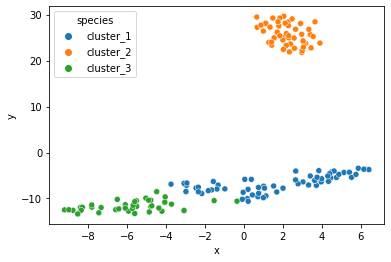

In [33]:
sns.scatterplot(x='x', y='y', hue='species', data=tsne_clusters_df)
plt.show()